# 6.多元卡尔曼滤波器

对多个随机变量进行滤波

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

# 简介

我们现在准备研究并实现卡尔曼滤波器的完整多变量形式。在上一章中，我们学习了多元高斯分布如何表达多个随机变量之间的相关性，比如飞机的位置和速度。我们也了解了变量之间的相关性是如何极大地改善后验估计的。如果我们大致知道位置和速度，但它们是相关的，那么我们的新估计可以非常准确。

我更希望你通过几个实例来建立这些滤波器的工作直觉。我将略过许多问题。我向你展示的一些内容只适用于特殊情况，其他内容可能会有一些“神奇”之处——我不会清楚地解释我是如何得到某个结果的。如果我一开始就使用严谨、广义的方程式，你可能会困惑不解这些术语的含义，以及如何将它们应用到你的问题中。在后面的章节中，我将提供更严谨的数学基础，在那时我将不得不纠正本章中所做的近似，或者提供我在此没有涵盖的额外信息。

为了实现这一点，我们将限制自己解决可以用牛顿运动方程描述的一些问题。这些滤波器被称为*离散化连续时间运动学滤波器*。在**卡尔曼滤波器数学**章节中，我们将为非牛顿系统开发数学基础。

# 牛顿运动方程

牛顿运动方程告诉我们，对于一个系统的恒定速度$v$，在时间$t$后可以计算其位置$x$：

$$x = vt + x_0$$

例如，如果我们从位置13开始，速度是10米/秒，旅行了12秒，最终位置是133（$10\times 12 + 13$）。

我们可以将恒定加速度纳入这个方程：

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

如果我们假设有恒定的jerk（加加速度），我们得到：

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

这些方程是通过对微分方程进行积分得到的。对于恒定速度$v$，我们可以用方程

$$x = vt + x_0$$

来计算随时间行驶的距离，我们可以用下面的步骤导出这个方程：

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

设计卡尔曼滤波器时，你会从描述系统动态的微分方程组开始。大多数微分方程组不容易通过这种方式积分。我们选择牛顿的方程因为我们可以进行积分并得到一个闭合形式的解，这使得卡尔曼滤波器更容易设计。另一个好处是牛顿方程是用于跟踪运动物体的正确方程之一，这也是卡尔曼滤波器的主要用途之一。

# 卡尔曼滤波器算法

这个算法与我们在每一章中使用的贝叶斯滤波器算法相同。更新步骤略微复杂一些，但等到讲解时我会解释其中的原因。

**初始化**

    1. 初始化滤波器的状态
    2. 初始化对状态的信念
    
**预测**

    1. 使用过程模型预测下一个时间步的状态
    2. 调整信念以考虑预测的不确定性    
    
**更新**

    1. 获取测量值及其相关的准确性信念
    2. 计算估计状态和测量之间的残差
    3. 基于测量或预测哪个更准确，计算缩放因子
    4. 根据缩放因子设置处于预测和测量之间的状态
    5. 根据我们对测量的确定程度更新对状态的信念
    
作为提醒，这里是算法的图形描述：

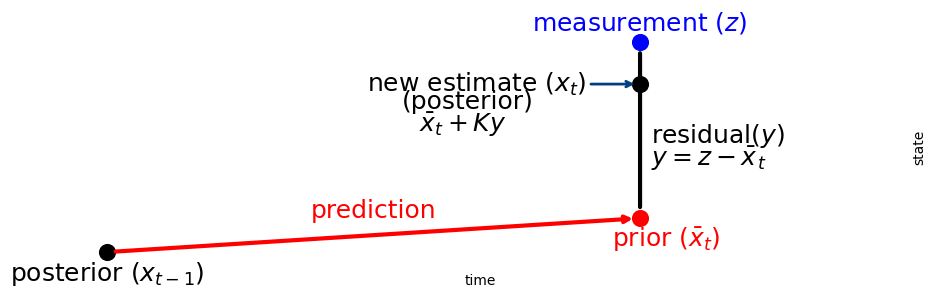

In [2]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

单变量卡尔曼滤波器使用单变量高斯分布表示状态。自然而然，多变量卡尔曼滤波器将使用多变量高斯分布来表示状态。在上一章中，我们了解到多变量高斯分布使用向量表示均值，使用矩阵表示协方差。这意味着卡尔曼滤波器需要使用线性代数来执行估计。

我不希望你死记这些方程，但我列出了单变量和多变量的方程如下。它们非常相似。

<u>**预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

$\mathbf x,\, \mathbf P$ 是状态的均值和协方差。它们对应于 $x$ 和 $\sigma^2$。

$\mathbf F$ 是*状态转移函数*。与 $\bf x$ 相乘会计算先验值。

$\mathbf Q$ 是过程协方差。它对应于 $\sigma^2_{f_x}$。

$\mathbf B$ 和 $\mathbf u$ 对我们来说是新的。它们允许我们对系统进行控制输入建模。

<u>**更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ 是测量函数。在本书中我们还没有看到它，我稍后会解释。如果你在方程中心先把 $\mathbf H$ 去掉，你会发现这些方程也是相似的。

$\mathbf z,\, \mathbf R$ 是测量均值和噪声协方差。它们对应于单变量滤波中的 $z$ 和 $\sigma_z^2$（为了使符号尽可能相似，我用 $x$ 替代了单变量方程中的 $\mu$）。

$\mathbf y$ 和 $\mathbf K$ 是残差和卡尔曼增益。

细节与单变量滤波器不同，因为这些是向量和矩阵，但概念上完全相同：

- 使用高斯分布表示我们对状态和误差的估计
- 使用高斯分布表示测量及其误差
- 使用高斯分布表示过程模型
- 使用过程模型来预测下一个状态（先验）
- 在测量和先验之间形成部分估计

作为设计者，你的任务是设计状态 $\left(\mathbf x, \mathbf P\right)$，过程 $\left(\mathbf F, \mathbf Q\right)$，测量 $\left(\mathbf z, \mathbf R\right)$ 和测量函数 $\mathbf H$。如果系统具有控制输入，比如一个机器人，你还需要设计 $\mathbf B$ 和 $\mathbf u$。

我已经将卡尔曼滤波器的方程编写到了FilterPy的`predict`和`update`函数中。你可以使用以下方式导入它们：

```python
from filterpy.kalman import predict, update
```

# 追踪一条狗

好的，我们回到跟踪狗的问题。这一次，我们将包括前一章的基本见解，并使用*隐藏变量*来改进我们的估计。我本可以从数学开始，但我们可以边实现滤波器边学习。表面上，这些数学与之前的章节有所不同，也许更加复杂，但思想都是相同的——我们只是在进行高斯分布的相加和相乘。

我们首先编写一个狗的模拟。这个模拟将运行 `count` 步，每一步大致向前移动一米。在每一步中，速度将根据过程方差 `process_var` 变化。在更新位置后，我们用假设的传感器方差 `z_var` 计算一个测量值。该函数返回一个包含位置的 NumPy 数组和一个包含测量值的数组。

In [3]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

# 预测步骤

对于预测，我们需要设计状态和协方差、过程模型和过程噪声，以及可选的控制输入。让我们按顺序来看待它们。

# 设计状态变量

在以前的问题中，我们通过使用高斯分布来跟踪狗的一维位置。均值$(\mu)$代表最可能的位置，方差$(\sigma^2)$表示位置的概率分布。位置是系统的*状态*，我们称$\mu$为*状态变量*。

在这个问题中，我们将跟踪狗的位置和速度。这需要我们使用由状态向量$\mathbf x$和相应的协方差矩阵$\mathbf P$表示的多元高斯分布。

状态变量可以是*观察变量*——由传感器直接测量，或者*隐藏变量*——从观察变量中推断得出。对于我们的狗跟踪问题，传感器只读取位置，因此位置是观察到的，而速度是隐藏的。我们将很快学习如何跟踪隐藏变量。

重要的是要理解，跟踪位置和速度是一种设计选择，有着我们尚未准备探索的影响和假设。例如，我们也可以跟踪加速度，甚至是加加速度。现在，回想一下在上一章中我们展示了在协方差矩阵中包含速度导致位置方差大大减小的情况。我们将在本章后面学习卡尔曼滤波器如何计算隐藏变量的估计。

在单变量章节中，我们用标量值表示狗的位置（例如$\mu=3.27$）。在上一章中，我们学会了使用多元高斯分布表示多个变量。例如，如果我们想指定一个位置为10.0米，速度为4.5米/秒，我们会写成：

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

卡尔曼滤波器使用线性代数实现。我们使用一个$n\times 1$矩阵（称为*向量*）来存储$n$个状态变量。对于狗跟踪问题，我们使用$x$表示位置，$x$的一阶导数$\dot x$表示速度。我使用牛顿的点符号表示导数；$\dot x$表示$x$关于$t$的一阶导数：$\dot x = \frac{dx}{dt}$。卡尔曼滤波器方程使用$\mathbf x$表示状态，因此我们定义$\mathbf x$为：

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

我们使用$\mathbf x$代替$\mu$，但要认识到这是多元高斯分布的均值。

另一种写法是$\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$，因为行向量的转置是列向量。这种记法在文本中更容易使用，因为占用的垂直空间更少。

$\mathbf x$和位置$x$恰好具有相同的名称。如果我们在y轴上跟踪狗，我们会写成$\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$，而不是$\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$。$\mathbf x$是卡尔曼滤波器文献中用于状态变量的标准名称，我们不会改变它以赋予更有意义的名称。这种命名的一致性使我们能够与同行进行交流。

让我们编写代码。初始化`x`就像是

In [4]:
x = np.array([[10.0],
              [4.5]])
x

array([[10. ],
       [ 4.5]])

我经常在代码中使用转置将行矩阵转换为列向量，因为我觉得这样更容易输入和阅读：

In [5]:
x = np.array([[10., 4.5]]).T
x

array([[10. ],
       [ 4.5]])

然而，NumPy将1维数组识别为向量，因此我可以简化这行代码以使用1维数组。

In [6]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

所有数组元素具有相同的类型，通常是`float`或`int`。如果列表包含全部为`int`，那么创建的数组也将具有`int`类型，否则将为`float`。我经常利用这一点，只指定一个数字为浮点数：

In [7]:
np.array([1., 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

这里有一些例子：

In [8]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.0], [4.5]])

# matrix multiply
print(np.dot(A, x))
print()

[[19.]
 [48.]]



在Python 3.5及以上版本中，我们有矩阵乘法操作符 `@`，其中`np.dot(A, B) == A @ B`。它可能比你想象的要稍微不太实用，因为它要求`A`和`B`都是数组。在本书的数学计算中，某些变量可以是标量，因此`@`的实用性经常被忽略。

In [9]:
# alternative matrix multiply)
print(A @ x)
print()

x = np.array([[10.0, 4.5]]).T
print(A @ x)
print()

x = np.array([10.0, 4.5])
print(A @ x)

[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]


最后的方法返回一个1维数组，但我编写的卡尔曼滤波器类可以处理这种情况。回想起来，这可能会导致混淆，但确实可以工作。

# 设计状态方差

状态高斯分布的另一半是协方差矩阵$\mathbf P$。在单变量卡尔曼滤波器中，我们为$\sigma^2$指定了初始值，随后滤波器在添加测量时负责更新其值。在多维卡尔曼滤波器中也是同样的情况。我们为$\mathbf P$指定一个初始值，并且滤波器在每个时间步更新它的值。

我们需要将方差设置为合理的值。例如，如果我们对初始位置非常不确定，我们可以选择$\sigma_\mathtt{pos}^2=500 m^2$。狗的最高速度约为21 m/s，因此在没有任何关于速度的其他信息的情况下，我们可以设置$3\sigma_\mathtt{vel}=21$，或$\sigma_\mathtt{vel}^2=7^2=49$。

在上一章中，我们展示了位置和速度是相关的。但是对于一只狗，它们有多相关呢？我不知道。正如我们将看到的，滤波器会为我们计算这一点，所以我将协方差初始化为零。当然，如果你知道这些协方差，你应该使用它们。

回想一下，协方差矩阵的对角线包含每个变量的方差，而非对角线元素包含协方差。因此，我们有：

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

我们可以使用`numpy.diag`，它从对角线的值创建一个对角矩阵。从线性代数中可以知道，对角矩阵的非对角线元素都是零。

In [10]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

我们完成了。我们已经将滤波器的状态表达为多元高斯，并在代码中实现了它。

# 设计过程模型

下一步是设计“过程模型”。它是描述系统行为的数学模型。滤波器使用它来预测离散时间步长后的状态。我们使用一组描述系统动态的方程来实现这一点。

在单变量章节中，我们用以下方式对狗的运动进行建模：

$$ x = v \Delta t + x_0$$

我们将其实现为：

```python
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, 
                    pos.var + movement.var)
```

在本章中，我们将做同样的事情，只是使用多元高斯而不是单元高斯。你可以想象这种实现方式：

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

但我们需要将其推广化。卡尔曼滤波器的方程适用于任何线性系统，而不仅仅是牛顿系统。也许你要过滤的系统是化工厂的管道系统，给定管道的流量由不同阀门设置的线性组合决定。

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

线性代数有一种表达系统方程的强大方式。考虑这个系统：

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

我们可以通过写出：

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

将其转化为矩阵形式。如果你在这个方程中进行[矩阵乘法](https://en.wikipedia.org/wiki/Matrix_multiplication#General_definition_of_the_matrix_product)，结果将是上述的两个方程。在线性代数中，我们会写成$\mathbf{Ax}=\mathbf B$，其中

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$

然后，我们可以使用SciPy的`linalg`包来求解$\mathbf x$：

In [11]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

我们使用过程模型进行*创新*，因为这些方程告诉我们，在当前状态下，下一个状态会是什么样子。卡尔曼滤波器使用以下线性方程来实现这一点，其中$\mathbf{\bar x}$是*先验*或预测状态：

$$\mathbf{\bar x} = \mathbf{Fx}$$

我们可以将其展开为：

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

我们作为卡尔曼滤波器设计者的任务是指定$\mathbf F$，使得$\bar{\mathbf x}  = \mathbf{Fx}$能够为我们的系统进行创新（预测）。为此，我们需要为每个状态变量提供一个方程。在我们的问题中，$\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$，因此我们需要一个方程来计算位置$x$，另一个方程来计算速度$\dot x$。我们已经知道位置创新的方程：

$$\bar x = x + \dot x \Delta t$$

那么我们的速度方程是什么呢？我们没有预测我们的狗的速度如何随时间变化的模型。在这种情况下，我们假设速度在创新之间保持不变。当然，这并不完全正确，但只要速度在每次创新过程中变化不大，你会发现滤波器的性能非常好。所以我们说

$$\bar{\dot x} = \dot x$$

这给了我们系统的过程模型

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

这样就正确地为状态中的每个变量分别列出了一个方程。我们需要将这组方程表达成形式为$\bar{\mathbf x}  = \mathbf{Fx}$。重新排列项可以更容易地看出应该怎么做。

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

我们可以将这个矩阵形式重写为

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$被称为*状态转移函数*或*状态转移矩阵*。在后面的章节中，它将成为一个真正的函数，而不是一个矩阵，所以称它为一个函数更加一般化。

In [12]:
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

很好！我们来测试一下吧！FilterPy有一个`predict`方法，通过计算$\mathbf{\bar x} = \mathbf{Fx}$来执行预测。让我们调用它来看看会发生什么。我们将位置设置为10.0，速度设置为4.5米/秒。我们定义了`dt = 0.1`，这意味着时间步长为0.1秒，因此我们预期创新后新的位置将是10.45米。速度不应发生变化。

In [13]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


没错！如果我们连续多次调用`predict()`，每次值都会被更新。

In [14]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


`predict()` 计算创新（预测）后的均值和协方差。这是经过五次创新（预测）后的 $\mathbf P$ 值，我们在卡尔曼滤波方程中表示为 $\mathbf{\bar P}$。

In [15]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


检查对角线可以发现位置方差变得更大了。我们进行了五次预测步骤没有进行测量，我们的不确定性增加了。非对角线元素变得非零 - 卡尔曼滤波器检测到了位置和速度之间的相关性！速度的方差没有变化。

我在此绘制了预测前后的协方差。初始值用实线红色表示，预测值用虚线黑色表示。我改变了协方差和时间步长以更好地说明变化。

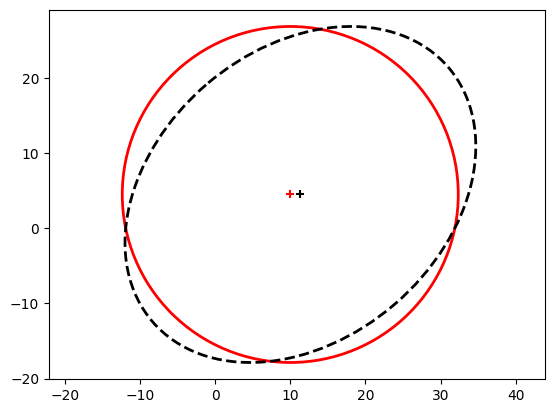

In [16]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

你可以看到椭圆的中心稍微移动了一点（从10到11.35），因为位置发生了变化。椭圆也变得更加椭圆，显示了位置和速度之间的相关性。滤波器是如何计算新的$\mathbf{\bar P}$值的？它基于什么？请注意，我每次将过程噪声`Q`设为零，因此这不是由我添加噪声导致的。现在讨论这个有点早，但回想一下到目前为止每个滤波器的预测步骤都意味着信息的丢失。这里也是一样的。一旦我们涵盖了更多内容，我会给你详细介绍。

# 设计过程噪声

白噪声是指具有恒定功率谱密度的随机信号，它在所有频率上均匀分布。在Kalman滤波器中，过程噪声表示系统中未知的随机因素对状态变化的影响。这可能包括环境变化、传感器误差等。过程噪声的协方差矩阵（通常表示为 $\mathbf Q$）用于描述这些未知因素如何影响状态的变化。

FilterPy 提供了计算这种噪声的协方差矩阵的函数。`Q_discrete_white_noise` 是其中一个函数，它以三个参数作为输入。`dim` 指定了矩阵的维数，`dt` 表示时间步长（秒），`var` 表示噪声的方差。简而言之，它将在给定时间段内对噪声进行离散化处理，以后我们会讨论更多相关的假设。以下代码计算了方差为 2.35，时间步长为 1 秒的白噪声的协方差矩阵：

In [17]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


# 设计控制方程

卡尔曼滤波器不仅仅是用来过滤数据的，它还允许我们将系统控制输入（比如机器人和飞机）纳入考虑。假设我们正在控制一个机器人。在每个时间步，我们会根据机器人当前位置和期望位置发送方向盘和速度信号给它。卡尔曼滤波器的方程将这些信息纳入到滤波方程中，基于当前速度和驱动电机的控制输入创建一个预测位置。记住，我们*绝对不会*丢弃信息。

对于线性系统，控制输入的影响可以用一组线性方程描述，我们可以用线性代数表示为

$$\Delta\mathbf x = \mathbf{Bu}$$

这里的$\mathbf u$是*控制输入*，$\mathbf B$是*控制输入模型*或*控制函数*。例如，$\mathbf u$可能是控制车轮电机转速的电压，而乘以$\mathbf B$则得到$\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$。换句话说，它必须计算由控制输入引起的$\mathbf x$的变化量。

因此，先验均值的完整卡尔曼滤波器方程为

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

这就是调用`KalmanFilter.predict()`时计算的方程。

你的狗可能被训练来响应语音命令。所有可用的证据表明，我的狗根本没有任何控制输入，所以我将$\mathbf B$设为零。在Python中，我们写成：

In [19]:
B = 0.  # my dog doesn't listen to me!
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [14.05  4.5 ]
P = [[907.0915 453.055 ]
 [453.055  504.7   ]]


将$\mathbf B$和$\mathbf u$设为零并不是必要的，因为`predict`函数默认会将它们设为0：

In [20]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]

array([ True,  True])

In [21]:
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1]

array([[ True,  True],
       [ True,  True]])

# 预测：总结

作为设计者，你的任务是指定以下矩阵：

* $\mathbf x$、$\mathbf P$：状态和协方差
* $\mathbf F$、$\mathbf Q$：过程模型和噪声协方差
* $\mathbf{B,u}$：可选的控制输入和函数

# 更新步骤

现在我们可以实现滤波器的更新步骤了。你只需要提供另外两个矩阵，它们很容易理解。

# 设计测量函数

卡尔曼滤波器在所谓的*测量空间*中计算更新步骤。在单变量章节中，我们大多忽略了这个问题，因为它增加了复杂性。我们使用传感器追踪了狗狗的位置，传感器报告了它的位置。计算*残差*很容易——将滤波器预测的位置从测量位置中减去：

$$ \mathtt{残差} = \mathtt{测量位置} - \mathtt{预测位置}$$

我们需要计算残差，因为我们需要用卡尔曼增益对其进行缩放以得到新的估计值。

如果我们尝试使用输出电压对应于温度读数的温度计来跟踪温度会发生什么？残差计算的方程将毫无意义；你不能将温度减去电压。

$$ \mathtt{残差} = \mathtt{电压} - \mathtt{温度}\;\;\;(荒谬!)$$

我们需要将温度转换为电压，这样我们才能进行减法运算。对于温度计，我们可能会写成：

```python
CELSIUS_TO_VOLTS = 0.21475
残差 = 电压 - (CELSIUS_TO_VOLTS * 预测温度)
```

卡尔曼滤波器通过让你提供一个*测量函数*来概括这个问题，该函数将状态转换为测量。

为什么我们要在测量空间工作？为什么不将电压转换为温度，从而使残差成为温度的差异呢？

我们无法这样做，因为大多数测量都不是*可逆*的。跟踪问题的状态包含了隐藏变量$\dot x$。没有办法将位置的测量转换为包含速度的状态。另一方面，将包含位置和速度的状态转换为只包含位置的等效“测量”是容易的。我们必须在测量空间中工作以使残差的计算成为可能。

测量$\mathbf z$和状态$\mathbf x$都是向量，所以我们需要使用矩阵来进行转换。卡尔曼滤波器执行这一步的方程是：

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

这里$\mathbf y$是残差，$\mathbf{\bar x}$是先验值，$\mathbf z$是测量，$\mathbf H$是测量函数。所以我们将先验值转换为测量，方法是将其与$\mathbf H$相乘，并将其从测量中减去。这给我们在测量空间中预测和测量之间的差异！

<img src="./figs/residual_chart_with_h.png">

我们需要设计 $\mathbf H$ 使得 $\mathbf{H\bar x}$ 得到一个测量结果。对于这个问题，我们有一个测量位置的传感器，所以 $\mathbf z$ 将是一个单变量向量：

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

残差方程将具有以下形式：

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

为了使 $\mathbf{Hx}$ 是一个 1x1 的矩阵，$\mathbf H$ 必须是一个 1x2 的矩阵。回想一下，矩阵 $m\times n$ 乘以 $n\times p$ 的矩阵会得到一个 $m\times p$ 的矩阵。

我们想要将位置 $x$ 乘以 1 以得到相应的位置测量。我们不需要使用速度来找到相应的测量，因此我们将 $\dot x$ 乘以 0。

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

因此，对于我们的卡尔曼滤波器，我们设置

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [22]:
H = np.array([[1., 0.]])

我们已经设计了大部分的卡尔曼滤波器。剩下的就是对传感器中的噪声进行建模。

# 设计测量

测量是用 $\mathbf z$ 来实现的，它是测量均值，还有 $\mathbf R$，是测量协方差。

$\mathbf z$ 很简单。它包含了测量结果作为一个向量。我们只有一个测量，所以我们有：

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

如果我们有两个传感器或者两个测量，我们会有：

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$

*测量噪声矩阵*模拟了传感器中的噪声，将其表示为协方差矩阵。在实践中，这可能会比较困难。一个复杂的系统可能有许多传感器，它们之间的相关性可能不明确，并且通常它们的噪声不是一个纯粹的高斯分布。例如，如果温度很高，传感器可能倾向于高读数，因此噪声不会均匀地分布在平均值的两侧。我们稍后会学习如何处理这些问题。

卡尔曼滤波器方程使用一个协方差矩阵 $\mathbf R$ 来表示测量噪声。该矩阵的维度是 $m{\times}m$，其中 $m$ 是传感器的数量。它是一个协方差矩阵，用于考虑传感器之间的相关性。我们只有一个传感器，所以 $\mathbf R$ 是：

$$\mathbf R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

如果 $\sigma^2_z$ 是 5 平方米，那么 $\mathbf R = \begin{bmatrix}5\end{bmatrix}$。

如果我们有两个位置传感器，第一个方差是 5 平方米，第二个方差是 3 平方米，我们会写成：

$$\mathbf R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

我们将方差放在对角线上，因为这是一个*协方差*矩阵，其中方差位于对角线上，如果有的话，协方差位于非对角线元素上。在这里，我们假设两个传感器之间的噪声没有相关性，所以协方差为 0。

对于我们的问题，我们只有一个传感器，所以我们可以这样实现：

In [23]:
R = np.array([[5.]])

我们通过调用 `update` 来执行更新步骤。

In [24]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.07153888 -1.98220902]


跟踪所有这些变量是很繁琐的，所以 FilterPy 还使用 `KalmanFilter` 类来实现这个滤波器。在本书的其余部分，我将使用这个类，但我想让你们看到这些函数的过程形式，因为我知道有些人不喜欢面向对象编程。

# 实现卡尔曼滤波器

我已经给了你所有滤波器的代码，现在让我们把它们整合到一个地方。首先，我们构建一个 `KalmanFilter` 对象。我们需要用 `dim_x` 参数指定状态中的变量数，用 `dim_z` 指定测量数。我们的状态中有两个随机变量和一个测量值，所以我们写成：

```python
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
```

这将创建一个对象，并为所有卡尔曼滤波器矩阵使用默认值：

In [25]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)
# etc...

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


现在我们用适用于我们问题的值初始化滤波器的矩阵和向量。我将这部分放在一个函数中，以便你可以为 `R`、`P` 和 `Q` 指定不同的初始值，并将其放在一个辅助函数中。我们将创建和运行许多这样的滤波器，这样做可以省去很多麻烦。

In [27]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

`KalmanFilter` 将 `R`、`P` 和 `Q` 初始化为单位矩阵，所以 `kf.P *= P` 是一种快速将所有对角线元素赋予相同标量值的方法。现在让我们创建滤波器：

In [28]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

你可以通过在命令行中输入该变量来检查滤波器所有属性的当前值。

In [29]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7fd30016e670>

剩下的就是编写运行卡尔曼滤波器的代码了。

In [30]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

这段代码是滤波器的完整代码，其中大部分是样板代码。我设计它具有足够的灵活性，可以在本章中支持多种用途，所以有点啰嗦。我们一行一行地来看看。

首先检查是否提供了 `zs` 中的测量数据。如果没有，则使用之前编写的 `compute_dog_data` 函数创建数据。

接下来的几行使用我们的辅助函数创建了一个卡尔曼滤波器。

```python
# create the Kalman filter
kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
```

我们只需要对每个测量执行卡尔曼滤波器的更新和预测步骤。`KalmanFilter` 类提供了两个方法 `update()` 和 `predict()` 用于此目的。`update()` 执行卡尔曼滤波器的测量更新步骤，因此它接受一个包含传感器测量的变量。

在没有保存结果的情况下，循环的代码是：

```python
for z in zs:
    kf.predict()
    kf.update(z)
```

每次调用 `predict()` 和 `update()` 都会修改状态变量 `x` 和协方差 `P`。因此，在调用 `predict()` 后，`kf.x` 包含先验值。在调用 `update()` 后，`kf.x` 包含后验值。状态和协方差保存在 `xs` 和 `cov` 中。

这实际上不能再简单了。随着我们解决更复杂的问题，这段代码基本上会保持不变；所有的工作都用于设置 `KalmanFilter` 的矩阵；执行滤波器是简单的。

代码的其余部分可选择性地绘制结果，然后返回保存的状态和协方差。

让我们运行一下。我们有 50 个带有方差为 10 的噪声和方差为 0.01 的过程的测量值。

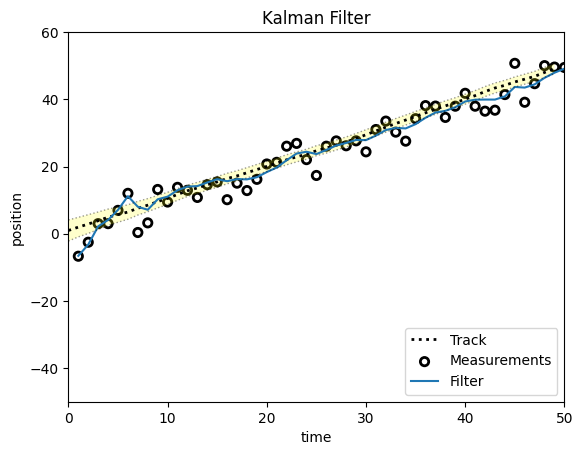

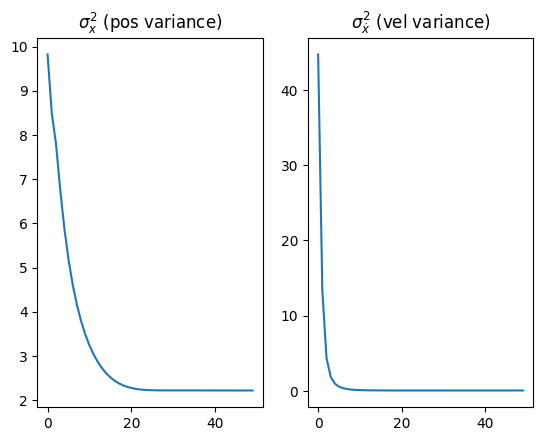

In [31]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

这只是开始，还有很多东西需要学习，但我们已经用与 Rudolf Kalman 发表的理论和方程非常相似的代码实现了一个卡尔曼滤波器！类似这样的代码在你的 GPS、客机、机器人等设备内部运行。

第一个图绘制了卡尔曼滤波器的输出与测量值以及我们狗狗的实际位置（标记为 *Track*）。在初始稳定期之后，滤波器应该能够非常接近地跟踪狗狗的位置。黑色虚线之间的黄色阴影部分显示了滤波器方差的一个标准差，我会在下一段解释这个。

接下来的两个图显示了 $x$ 和 $\dot x$ 的方差。我绘制了随时间变化的 $\mathbf P$ 的对角线。回想一下，协方差矩阵的对角线包含了每个状态变量的方差。所以 $\mathbf P[0,0]$ 是 $x$ 的方差，$\mathbf P[1,1]$ 是 $\dot x$ 的方差。你可以看到我们很快就收敛到了很小的方差。

协方差矩阵 $\mathbf P$ 告诉我们滤波器的 *理论* 性能，*假设* 我们告诉它的一切都是真实的。回想一下，标准差是方差的平方根，大约 68% 的高斯分布在一个标准差内。如果至少有 68% 的滤波器输出在一个标准差内，那么滤波器可能表现良好。在顶部图表中，我显示了一个标准差，即在两条虚线之间的黄色阴影区域。在我看来，滤波器似乎可能略微超出了这个范围，所以滤波器可能需要一些调整。

在单变量章节中，我们使用比上面代码简单得多的代码过滤了非常嘈杂的信号。然而，请意识到，现在我们正在处理一个非常简单的例子 - 一个在一维空间中移动的物体和一个传感器。这几乎是我们可以用上一章节的代码计算的极限。相比之下，我们可以通过修改对滤波器变量的赋值，仅仅用这一章节的代码实现非常复杂的多维滤波器。也许我们想要在金融模型中跟踪 100 个维度。或者我们有一架飞机配备了 GPS、惯性导航系统、TACAN、雷达高度计、气压高度计和空速指示器，我们想要将所有这些传感器整合到一个模型中，预测在三维空间中的位置、速度和加速度。我们可以使用本章的代码实现这些。

我想让你更好地感受高斯分布随时间的变化，所以这里是一个 3D 图，显示了每隔 7 个时刻（时间步长）的高斯分布。每隔 7 个时刻，它们足够分开，以便我们可以独立地看到每一个。$t=0$ 时刻的第一个高斯分布在左边。

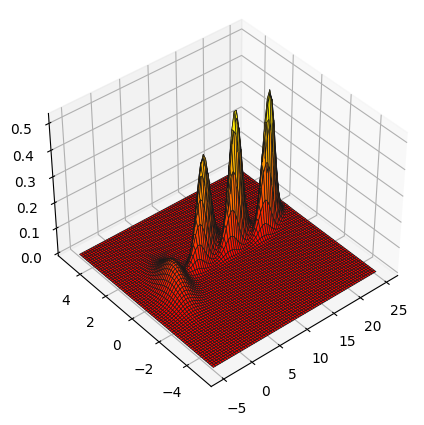

In [32]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

# 保存器类

在 `run()` 方法中，我编写了样板代码来保存滤波器的结果：

```python
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
```

有一个简单的方法可以避免这种重复。`filterpy.common` 提供了 `Saver` 类，每次调用 `Saver.save()` 时，它将保存卡尔曼滤波器类中的所有属性。让我们看看它的实际应用，然后我们再详细讨论。

In [33]:
from filterpy.common import Saver
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state

`Saver` 对象现在包含了 KalmanFilter 对象所有属性的列表。`kf.x` 是滤波器的当前状态估计。因此，`s.x` 包含了在循环内计算的保存的状态估计值：

In [34]:
s.x

[array([0.53063885, 0.3041721 ]),
 array([1.55544446, 0.76347564]),
 array([2.78435899, 1.03588193]),
 array([3.94381847, 1.10519678]),
 array([5.01546601, 1.08642624])]

你可以使用 `keys` 属性查看所有可用的属性：

In [35]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

那里有许多我们还没有讨论过的属性，但很多应该很熟悉。

在这一点上，你可以编写代码来绘制任何这些变量。然而，通常更有用的是使用 `np.array` 而不是列表。调用 `Saver.to_array()` 将列表转换为 `np.array`。有一个注意事项：如果在运行过程中任何属性的形状发生变化，`to_array` 将会引发异常，因为 `np.array` 要求所有元素具有相同的类型和大小。

如果你再次查看键，你会发现 `z` 是其中之一。这很有希望；显然测量 `z` 已经为我们保存下来了。让我们将其与估计值绘制出来。

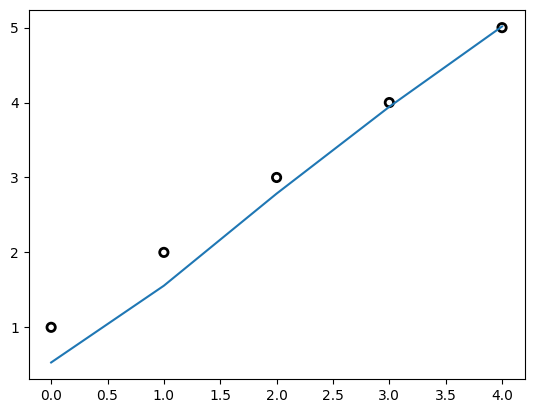

In [36]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z);
plt.plot(s.x[:, 0]);

我用 `KalmanFilter` 类演示了这一点，它将适用于 `FilterPy` 中实现的所有滤波器类。实际上，它可能也适用于你编写的任何类，因为它会检查对象以检索属性名称。在整本书中，我们将使用这个类来保持代码的可读性和简洁性。使用 `Saver` 会减慢你的代码，因为幕后发生了很多事情，但对于学习和探索来说，这种方便无可比拟。

# 卡尔曼滤波器方程

我们现在准备学习 `predict()` 和 `update()` 如何执行它们的计算。

关于符号表示法。我是一名程序员，习惯于阅读如下代码：

```python
x = x + 1
```

这不是一个等式，因为两边不相等，而是一个*赋值*。如果我们想用数学符号表示，我们会写成
$$x_k = x_{k-1} + 1$$

卡尔曼滤波器方程中充斥着下标和上标，以保持数学上的一致性。我发现这使得它们非常难以阅读。在本书的大部分内容中，我选择不使用下标的赋值方式。作为一名程序员，你应该理解我展示的是一步步执行的算法实现。一旦我们有具体的例子，我会详细解释这一点。

# 预测方程

卡尔曼滤波器使用以下方程计算系统的*先验*，即系统的预测下一个状态。它们计算系统的先验均值 ($\bar{\mathbf x}$) 和协方差 ($\bar{\mathbf P}$)。

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

$\underline{\textbf{均值}}$

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

作为提醒，线性方程 $\mathbf{Ax} = \mathbf b$ 表示一组方程组，其中 $\mathbf A$ 包含方程组的系数，$\mathbf x$ 是变量向量。执行乘法 $\mathbf{Ax}$ 计算该方程组的右侧值，用 $\mathbf b$ 表示。

如果 $\mathbf F$ 包含给定时间步长的状态转移，那么乘积 $\mathbf{Fx}$ 计算了该转移后的状态。简单吧！同样，$\mathbf B$ 是控制函数，$\mathbf u$ 是控制输入，因此 $\mathbf{Bu}$ 计算了控制对转移后状态的贡献。因此，先验 $\mathbf{\bar x}$ 计算为 $\mathbf{Fx}$ 和 $\mathbf{Bu}$ 的和。

相应的一元方程是

$$\bar\mu = \mu + \mu_{move}$$

如果执行矩阵乘法 $\mathbf{Fx}$，它将为 $x$ 生成这个方程。

让我们将这一点具体化。回顾上一章节中 $\mathbf F$ 的值：

$$\mathbf F = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}$$

因此 $\mathbf{\bar x} = \mathbf{Fx}$ 对应于以下线性方程组：

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

$\underline{\textbf{协方差}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

这个方程不太容易理解，所以我们会花更多时间来讲解。

在单变量版本的方程中是：

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$

我们将运动的方差加到我们估计的方差中，以反映出知识的损失。我们需要在这里做同样的事情，但是在多元高斯分布中不是那么简单。

我们不能简单地写成 $\mathbf{\bar P} = \mathbf P + \mathbf Q$。在多元高斯分布中，状态变量是*相关*的。这意味着什么？我们对速度的了解并不完美，但是我们将其加到位置上：

$$\bar x = \dot x\Delta t + x$$

由于我们对 $\dot x$ 的值不是完美了解，因此 $\bar x = \dot x\Delta t + x$ 的和变得更加不确定。因为位置和速度是相关的，我们不能简单地加上协方差矩阵。例如，如果 $\mathbf P$ 和 $\mathbf Q$ 是对角矩阵，它们的和也将是对角矩阵。但我们知道位置与速度是相关的，因此非对角线元素应该不为零。

正确的方程是

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$

在线性代数中，形式为 $\mathbf{ABA}^\mathsf T$ 的表达式很常见。你可以将它看作是通过外部项对中间项进行*投影*。我们将在本书的其余部分多次使用这种方法。我承认这可能对你来说是一个'神奇'的方程。让我们来探讨一下。

当我们用以下值初始化 $\mathbf P$ 时：

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$


$\mathbf{FPF}^\mathsf T$ 的值是：

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$

初始值的 $\mathbf P$ 之间没有位置和速度的协方差。位置被计算为 $\dot x\Delta t + x$，所以位置和速度之间存在相关性。乘法 $\mathbf{FPF}^\mathsf T$ 计算了 $\sigma_v^2 \Delta t$ 的协方差。确切的值并不重要；你只需要认识到 $\mathbf{FPF}^\mathsf T$ 利用过程模型自动计算了位置和速度之间的协方差！

另一种思考方法是考虑 $\mathbf{Fx}$ 的乘法。它将 $\mathbf x$ 向前投影了一段时间。$\mathbf {FP}$ 看起来可能是等效的操作，但 $\mathbf P$ 是一个矩阵，而 $\mathbf x$ 是一个向量。最后的 $\mathbf F^\mathsf T$ 确保我们通过 $\mathbf F$ 的所有行和列进行了乘法。在 $\mathbf{FPF}^\mathsf T$ 计算的第二行中，我们得到了 $\mathbf{FP}$ 的值。你可以看到它是一个上三角矩阵，因为我们还没有完全将 $\mathbf F$ 合并到乘法中。

如果你对线性代数和统计学有一些经验，这可能会有所帮助。预测引起的协方差可以被建模为预测步骤中误差的期望值，由以下方程给出：

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx - F\bar \mu})(\mathbf{Fx - F\bar\mu})^\mathsf T]\\
 &= \mathbf F\, \mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$

当然，$\mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]$ 就是 $\mathbf P$，这给了我们

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$

让我们看看它的效果。这里我使用我们滤波器的 $\mathbf F$，将状态向前投影了 6/10 秒。我做了五次，这样你就可以看到 $\mathbf{\bar P}$ 是如何不断变化的。

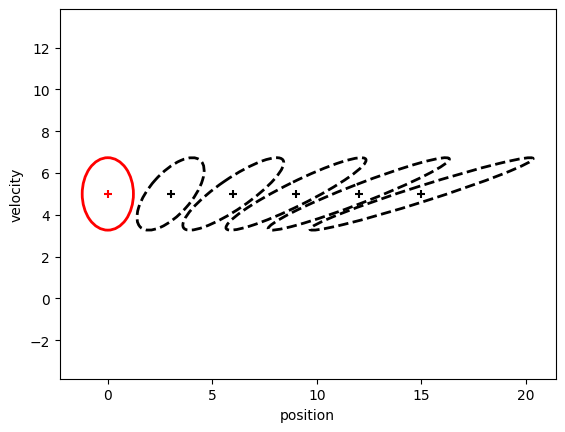

In [37]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

你可以看到，当速度为 5 时，位置在每个 6/10 秒步长中正确地移动了 3 个单位。在每个步骤中，椭圆的宽度都变大了，这表明由于在每个步骤中将 $\dot x\Delta t$ 加到 x 上，我们丢失了关于位置的信息。高度没有改变——我们的系统模型表明速度不变，因此我们对速度的信念不能改变。随着时间的推移，你可以看到椭圆变得越来越倾斜。回想一下，倾斜表示*相关性*。$\mathbf F$ 通过表达式 $\bar x = \dot x \Delta t + x$ 线性相关了 $x$ 和 $\dot x$。$\mathbf{FPF}^\mathsf T$ 的计算正确地将这种相关性合并到协方差矩阵中。

这是一个动画演示了这个方程，允许你改变 $\mathbf F$ 的设计以查看它如何影响 $\mathbf P$ 的形状。`F00` 滑块影响 F[0, 0] 的值。`covar` 设置位置和速度之间的初始协方差($\sigma_x\sigma_{\dot x}$)。我建议至少回答以下问题：

- 如果 $x$ 与 $\dot x$ 不相关会怎样？（将 F01 设置为 0，其余默认）
- 如果 $x = 2\dot x\Delta t + x_0$ 会怎样？（将 F01 设置为 2，其余默认）
- 如果 $x = \dot x\Delta t + 2x_0$ 会怎样？（将 F00 设置为 2，其余默认）
- 如果 $x = \dot x\Delta t$ 会怎样？（将 F00 设置为 0，其余默认）

In [38]:
from ipywidgets import interact
from kf_book.book_plots import IntSlider, FloatSlider

def plot_FPFT(F00, F01, F10, F11, covar):   
    plt.figure()
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, F @ P @ F.T, ec='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    #plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.show()
                 
interact(plot_FPFT, 
         F00=IntSlider(value=1, min=0, max=2), 
         F01=FloatSlider(value=1, min=0, max=2, description='F01(dt)'),
         F10=FloatSlider(value=0, min=0, max=2),
         F11=FloatSlider(value=1, min=0, max=2),
         covar=FloatSlider(value=0, min=0, max=1));

interactive(children=(IntSlider(value=1, continuous_update=False, description='F00', max=2), FloatSlider(value…

# 更新方程

更新方程看起来比预测方程更混乱，但这主要是因为卡尔曼滤波器在测量空间中进行更新计算。这是因为测量并不是*可逆的*。例如，考虑一个传感器，它给出到目标的距离。将距离转换为位置是不可能的 - 圆圈中无限多个位置会产生相同的距离。另一方面，我们总是可以根据位置（状态）计算出距离（测量）。

在我继续之前，回想一下我们试图做的是非常简单的事情：在测量和预测之间选择一个新的估计值，就像这个图表中所示：

<img src="./figs/residual_chart.png">

方程会变得复杂，因为状态具有多个维度，但我们正在进行的操作就是这样的。不要让方程让你忘记这个想法的简单性。

$\underline{\textbf{系统的不确定性}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R$

为了让卡尔曼滤波器在测量空间中工作，必须将协方差矩阵投影到该空间中。这个过程的数学表达式是 $\mathbf{H\bar PH}^\mathsf T$，其中 $\mathbf{\bar P}$ 是*先验*协方差，$\mathbf H$ 是测量函数。

你应该能够辨认出这种 $\mathbf{ABA}^\mathsf T$ 的形式 - 在预测步骤中，使用 $\mathbf{FPF}^\mathsf T$ 以状态转移函数更新 $\mathbf P$。在这里，我们用相同的形式来用测量函数更新它。线性代数为我们改变了坐标系。

一旦协方差处于测量空间中，我们需要考虑传感器噪声。这很简单 - 我们只需将矩阵相加。结果通常称为*系统不确定性*或*创新协方差*。

如果忽略 $\mathbf H$ 项，这个方程等同于卡尔曼增益单变量方程的分母部分：

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

比较系统不确定性和协方差的方程：

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

在每个方程中，$\mathbf P$ 被放入不同的空间，分别使用函数 $\mathbf H$ 或 $\mathbf F$。然后我们加上与该空间相关的噪声矩阵。

$\underline{\textbf{卡尔曼增益}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

回顾一下残差图表。一旦我们有了预测值和测量值，我们需要在两者之间选择一个估计值。如果我们对测量值更有确定性，估计值将更接近于它。相反，如果我们对预测值更有确定性，那么估计值将更接近于预测值。

在单变量章节中，我们使用了以下方程对均值进行了缩放：

$$
\mu =\frac{\bar\sigma^2 \mu_z + \sigma_\mathtt{z}^2 \bar\mu} {\bar\sigma^2 + \sigma_\mathtt{z}^2}$$

可以简化为：

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

然后就得到了

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

$K$ 是*卡尔曼增益*，它是一个介于 0 和 1 之间的实数。确保你理解它是如何在预测值和测量值之间选择一个均值的。卡尔曼增益是一个*百分比*或*比率* - 如果 $K$ 是 0.9，它就是测量值的 90%，预测值的 10%。

对于多变量卡尔曼滤波器，$\mathbf K$ 是一个向量，而不是标量。这是方程：$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$。这是一个*比率*吗？我们可以把矩阵的逆看作是线性代数中找到倒数的方式。矩阵并不具有除法的定义，但这种方式的思考是有用的。所以我们可以将 $\textbf{K}$ 的方程理解为

$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$

卡尔曼增益方程根据我们对预测值和测量值的信任程度计算一个比率。在以前的每个章节中，我们都做过同样的事情。这个方程之所以复杂，是因为我们通过矩阵在多个维度上进行操作，但概念很简单。$\mathbf H^\mathsf T$ 项不太清楚，我马上会解释它。如果忽略那个项，卡尔曼增益的方程与单变量情况相同：将先验的不确定性除以先验不确定性与测量不确定性之和。

$\underline{\textbf{残差}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

这个很简单，因为在设计测量函数 $\mathbf H$ 时我们已经涉及到了这个方程。回想一下，测量函数将状态转换为测量。所以 $\mathbf{Hx}$ 将 $\mathbf x$ 转换为相应的测量。一旦完成这一步，我们可以将其从测量 $\mathbf z$ 中减去，得到残差 - 测量值和预测值之间的差异。

单变量方程是

$$y = z - \bar x$$

很明显地，它计算的是相同的事情，只是在单维度上。

$\underline{\textbf{状态更新}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

我们选择新的状态沿着残差的方向，并由卡尔曼增益进行缩放。缩放由 $\mathbf{Ky}$ 完成，它既对残差进行了缩放，又通过 $\mathbf H^\mathsf T$ 项将其转换回状态空间，这个项包含在 $\mathbf K$ 中。将其加到先验中，得到方程：$\mathbf x =\mathbf{\bar x} + \mathbf{Ky}$。让我写出 $\mathbf K$，这样我们就可以看到整个计算过程：

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T \mathbf y
\end{aligned}$$

也许更好地*理解*这个比率的方法是重新书写估计方程：

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$

这个与单变量形式之间的相似性应该是显而易见的：

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

$\underline{\textbf{协方差更新}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ 是单位矩阵，用来表示多维度中的 $1$。$\mathbf H$ 是我们的测量函数，是一个常数。我们可以将方程理解为 $\mathbf P = (1-c\mathbf K)\mathbf P$。$\mathbf K$ 是我们用于预测和测量的比率。如果 $\mathbf K$ 很大，那么 $(1-\mathbf{cK})$ 很小，$\mathbf P$ 将会比原来小。如果 $\mathbf K$ 很小，那么 $(1-\mathbf{cK})$ 很大，$\mathbf P$ 将相对较大。这意味着我们通过卡尔曼增益的某个因子来调整我们不确定性的大小。

这个方程在数值上可能不稳定，在 FilterPy 中我不使用它。减法可能破坏对称性，并随着时间推移导致浮点误差。稍后我会分享更复杂但数值稳定的方程形式。

# 不使用 FilterPy 的示例

FilterPy将实现的细节隐藏起来了。通常你会感到这样更方便，但是让我们在没有FilterPy的情况下实现最后一个滤波器。为此，我们需要将矩阵定义为变量，然后明确地实现卡尔曼滤波方程。

以下是我们初始化矩阵的代码：

In [39]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

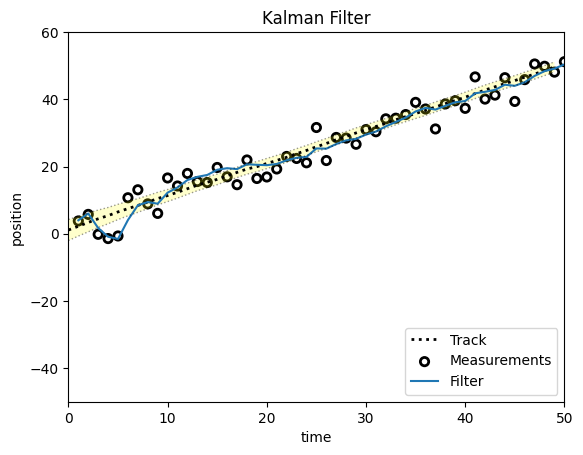

In [40]:
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)

结果与FilterPy版本相同。你更喜欢哪个取决于你。我更倾向于不在我的命名空间中污染变量，比如 `x`、`P` 等等；对我来说，`dog_filter.x` 更易读。

更重要的是，这个例子需要你记住并编写卡尔曼滤波器的方程。迟早你会犯错。FilterPy的版本确保了你的代码是正确的。另一方面，如果你在定义中犯了错误，比如将 $\mathbf H$ 设为列向量而不是行向量，FilterPy的错误消息将比这个显式代码更难调试。

FilterPy的KalmanFilter类提供了额外的功能，比如平滑、批处理、衰减记忆滤波、最大似然函数的计算等等。你可以在不需要显式编程的情况下获得所有这些功能。

# 总结

我们已经学习了卡尔曼滤波器的方程。以下是它们全部内容，供你复习。学习过程中内容较多，但我希望你在学习每个方程时能意识到它与单变量滤波器中的方程的相似性。在*卡尔曼数学*章节中，我会向你展示，如果我们将 $\mathbf x$ 的维度设置为一维，这些方程将回归到单变量滤波器的方程。这不仅仅是“类似”单变量滤波器 - 它是其多维度的实现。

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$

当然，我可以和你分享一种在文献中常见的方程形式。使用的符号系统有很多不同，但这会让你对期望看到的内容有所了解。

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

这种符号表示使用了贝叶斯的 $a\mid b$ 表示法，表示给定 $b$ 的证据下的 $a$。帽子表示估计。因此，$\hat{\mathbf x}_{k\mid k}$ 表示在步骤 $k$（第一个 $k$）给定步骤 $k$（第二个 $k$）的证据下对状态 $\mathbf x$ 的估计。换句话说，是后验。$\hat{\mathbf x}_{k\mid k-1}$ 表示在步骤 $k$ 给定步骤 $k - 1$ 的估计下对状态 $\mathbf x$ 的估计。换句话说，是先验。

这种符号，摘自[Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter#Details) [[1]](#[wiki_article])，允许数学家准确表达自己。在正式发表新结果的学术著作中，这种精确性是必需的。作为程序员，我觉得这种表示方法相当晦涩难懂。我习惯于思考程序运行过程中变量的变化，不会为每次计算使用不同的变量名称。在文献中并没有统一的格式，所以每个作者都做出了不同的选择。我发现快速切换不同书籍和论文是具有挑战性的，因此采用了我承认不够精确的符号表示。数学家们可能会写尖刻的邮件给我，但我希望程序员和学生们能对我的简化符号表示感到高兴。

**符号表**附录列出了各种作者使用的符号表示法。这引出了另一个困难。不同的作者使用不同的变量名。$\mathbf x$ 是相当通用的，但除此之外就很难说了。例如，通常使用 $\mathbf{A}$ 来表示我称为 $\mathbf F$ 的矩阵。你必须仔细阅读，并希望作者定义他们的变量（他们通常不会这样做）。

如果你是一位程序员试图理解论文中的方程，我建议首先删除所有上标、下标和变音符号，用一个单独的字母代替它们。如果你每天都使用这种方程，这些建议可能有点多余，但当我阅读时，我通常试图理解计算的流程。对我来说，记住在这一步中 $P$ 代表着上一步中计算出的 $P$ 的更新值，要比记住 $P_{k-1}(+)$ 表示什么、它与 $P_k(-)$ 有什么关系（如果有的话），以及这些与我5分钟前读到的完全不同的符号表示法有什么关系，要容易得多。